In [2]:
from google.colab import drive
import zipfile
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the path to the ZIP file in your Google Drive
zip_file_path = '/content/drive/MyDrive/zip-folder.zip'  # Replace with your actual file path
extract_to_path = '/content/extracted_files'  # Directory where the ZIP file will be extracted

# Step 3: Create the extraction directory if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Step 4: Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Files extracted to: {extract_to_path}")

Mounted at /content/drive
Files extracted to: /content/extracted_files


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [4]:
# Set paths to your dataset folders
train_dir = '/content/extracted_files/train'
val_dir = '/content/extracted_files/val'
test_dir = '/content/extracted_files/test'

In [5]:
# Hyperparameters
batch_size = 32
image_size = (224, 224)  # MobileNet requires 224x224 input size
epochs = 20
learning_rate = 0.001

In [6]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [7]:
# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6953 images belonging to 100 classes.
Found 1966 images belonging to 100 classes.
Found 1034 images belonging to 100 classes.


In [8]:
# Load Pre-trained MobileNet Model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
# Freeze the base model
base_model.trainable = False

In [10]:
# Add Custom Layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [11]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 105s 431ms/step - accuracy: 0.1575 - loss: 3.9769 - val_accuracy: 0.5651 - val_loss: 1.7548
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 130s 404ms/step - accuracy: 0.5872 - loss: 1.6721 - val_accuracy: 0.7889 - val_loss: 0.8668
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 142s 397ms/step - accuracy: 0.7609 - loss: 0.9301 - val_accuracy: 0.8642 - val_loss: 0.5305
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 142s 405ms/step - accuracy: 0.8383 - loss: 0.6444 - val_accuracy: 0.9252 - val_loss: 0.3099
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 88s 394ms/step - accuracy: 0.8796 - loss: 0.4559 - val_accuracy: 0.9502 - val_loss: 0.1982
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 147s 415ms/step - accuracy: 0.9125 - loss: 0.3441 - val_accuracy: 0.9446 - val_loss: 0.2069
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 138s 396ms/step - accuracy: 0.9218 - loss: 0.2968 - val_accuracy: 0.9705 - val_loss: 0.1297
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 146s 416ms/step - accuracy: 0.9330 - loss: 0.241

In [14]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Train Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy * 100:.2f}%")

218/218 ━━━━━━━━━━━━━━━━━━━━ 92s 423ms/step - accuracy: 0.9679 - loss: 0.1140
Train Loss: 0.1047	Train Accuracy: 96.95%


In [16]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}\tTest Accuracy: {test_accuracy * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9962 - loss: 0.0159
Test Loss: 0.0278	Test Accuracy: 99.23%


In [17]:
# Unfreeze the base model and fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=learning_rate / 10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10
history_fine_tune = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator
)

Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 146s 516ms/step - accuracy: 0.5795 - loss: 2.6112 - val_accuracy: 0.9257 - val_loss: 0.2397
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 104s 423ms/step - accuracy: 0.9272 - loss: 0.2282 - val_accuracy: 0.9807 - val_loss: 0.0628
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 146s 434ms/step - accuracy: 0.9671 - loss: 0.1047 - val_accuracy: 0.9852 - val_loss: 0.0399
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 140s 435ms/step - accuracy: 0.9745 - loss: 0.0742 - val_accuracy: 0.9954 - val_loss: 0.0112
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 97s 430ms/step - accuracy: 0.9839 - loss: 0.0535 - val_accuracy: 0.9959 - val_loss: 0.0160
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 143s 435ms/step - accuracy: 0.9864 - loss: 0.0576 - val_accuracy: 0.9969 - val_loss: 0.0111
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 100s 447ms/step - accuracy: 0.9900 - loss: 0.0360 - val_accuracy: 0.9975 - val_loss: 0.0066
Epoch 8/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 140s 439ms/step - accuracy: 0.9933 - 

In [18]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Train Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy * 100:.2f}%")

218/218 ━━━━━━━━━━━━━━━━━━━━ 89s 409ms/step - accuracy: 0.9873 - loss: 0.0420
Train Loss: 0.0400	Train Accuracy: 98.81%


In [20]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}\tTest Accuracy: {test_accuracy * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9983 - loss: 0.0104
Test Loss: 0.0071	Test Accuracy: 99.90%


In [21]:
model.save('mobilenet_finetuned.h5')

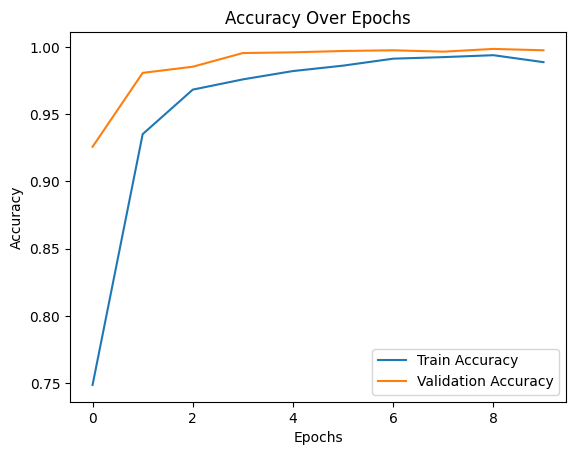

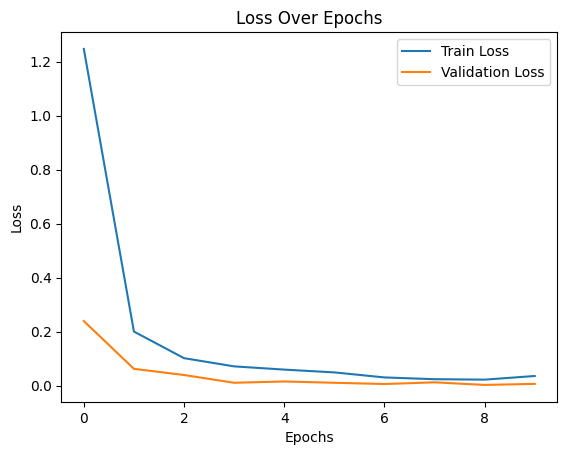

In [22]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_fine_tune.history['loss'], label='Train Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model.save('mobilenet_finetuned.keras')